# Example on the urban canopy data 

In [1]:
from pivpy import io, graphics, pivpy
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pkg_resources as pkg
%matplotlib inline

In [2]:
from lvreader import read_buffer
from lvreader.frame import VectorFrame
from lvreader.plot import plot_vector_field, prettify_plot
# import pathlib
# vc7file = pathlib.Path('../../pivpy/data/VC7/2d2c/2Ca.vc7')
buffer = read_buffer(pkg.resource_filename('pivpy','data/urban_canopy/B00001.vc7'))
# print(buffer)

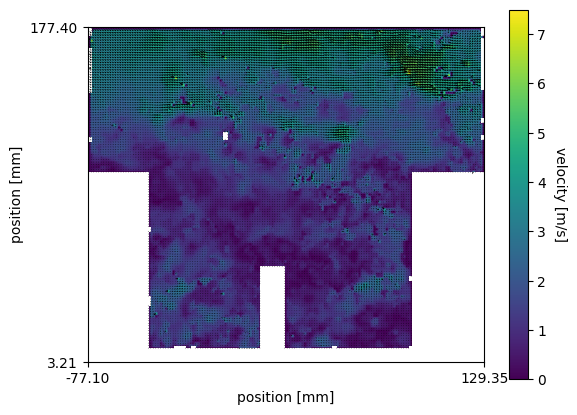

In [3]:
buffer.plot()

In [4]:
data = buffer[0]
data.shape, data.scales, data.enabled, data.grid

((135, 160),
 Scales(x=Scale(slope=0.0806436, offset=-77.0953, unit='mm', description='position'), y=Scale(slope=-0.0806436, offset=177.401, unit='mm', description='position'), z=Scale(slope=1.0, offset=0.0, unit='pixel', description=''), i=Scale(slope=0.268812, offset=0.0, unit='m/s', description='velocity')),
 [array([[0, 1, 1, ..., 1, 1, 0],
         [1, 1, 1, ..., 1, 1, 0],
         [1, 1, 1, ..., 1, 1, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)],
 Grid(x=16, y=16, z=16))

In [5]:
plane = 0

u = data.components["U0"][plane]
v = data.components["V0"][plane]

In [6]:
mask = np.logical_not(data.masks[plane] & data.enabled[plane])
# We can't just leave arbitrary values in masked areas, or they would
# produce overflow warnings and invalid value warnings during plotting:
u[mask] = 0.0
v[mask] = 0.0
# mask.harden_mask()

# scale
u = data.scales.i.offset + u*data.scales.i.slope
v = data.scales.i.offset + v*data.scales.i.slope



In [7]:
x = np.arange(u.shape[1])
y = np.arange(u.shape[0])

x = data.scales.x.offset + (x+.5)*data.scales.x.slope*data.grid.x
y = data.scales.y.offset + (y+.5)*data.scales.y.slope*data.grid.y

x,y = np.meshgrid(x,y)

In [8]:
x.shape, u.shape

((135, 160), (135, 160))

In [9]:
dataset = io.create_sample_field(rows=x.shape[0], cols=x.shape[1])
# assign arrays
dataset["x"] = x[0, :]
dataset["y"] = y[:, 0]
dataset["u"] = xr.DataArray(u[:, :, np.newaxis], dims=("y", "x", "t"))
dataset["v"] = xr.DataArray(v[:, :, np.newaxis], dims=("y", "x", "t"))
dataset["chc"] = xr.DataArray(mask[:, :, np.newaxis], dims=("y", "x", "t"))


KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f7484516f70> (for post_execute):


KeyboardInterrupt: 

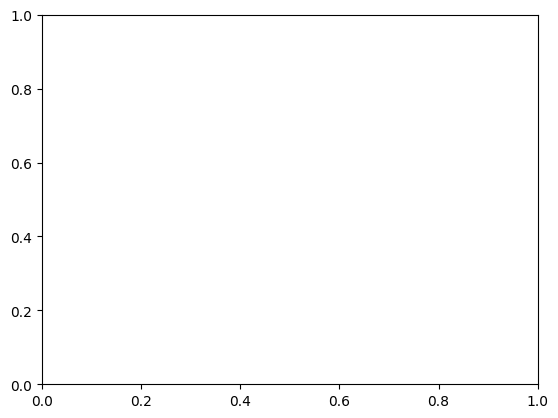

In [30]:
fig,ax = plt.subplots()
da = dataset.isel(t=0)
da['scalar'] = np.sqrt(da.u**2 + da.v**2)
xr.plot.pcolormesh(da, x='x',y='y',hue='scalar')
# da.plot.quiver(x='x',y='y',u='u',v='v',ax=ax)

# ax.invert_yaxis()

In [ ]:
# scale first
# self.scales.i.offset + values * self.scales.i.slope
# u = scale(u)
#  



background = np.sqrt(u * u + v * v)

fig, ax = plt.subplots()
image = ax.imshow(background)
ax.quiver(u, v, angles='xy', width=0.002)

colorbar = fig.colorbar(image)
colorbar.ax.yaxis.labelpad = 15
colorbar.ax.set_ylabel(data.scales.i.label(), rotation=270)


from matplotlib.ticker import FuncFormatter, LinearLocator

ax.xaxis.set_major_locator(LinearLocator(2))    
ax.yaxis.set_major_locator(LinearLocator(2))

ax.set_xticklabels([x.min(), x.max()])
ax.set_yticklabels([y.max(), y.min()])



In [ ]:
def scaled_coordinate(value, axis, scales, grids):
    # we want 0 to be top left edge, not center of top left pixel/vector:
    corrected = value + 0.5
    grid = 1 if grids is None else getattr(grids, axis)
    scale = getattr(scales, axis)
    return corrected * grid * scale.slope + scale.offset

In [ ]:
def prettify_plot(fig, scales, grids=None):
    """
    Adorns a given figure with labels and a color bar.
    Also sets exactly two ticks on each axis (one at each end)
    to make the data range clearly visible, and rounds their labels
    if possible without them becoming indistinguishable.
    """
    from matplotlib.ticker import FuncFormatter, LinearLocator

    [ax] = fig.axes
    ax.xaxis.set_major_locator(LinearLocator(2))
    ax.yaxis.set_major_locator(LinearLocator(2))

    def make_formatter(axis, *, rounded):
        @FuncFormatter
        def formatter(value, _=None):
            scaled = scaled_coordinate(value, axis, scales, grids)
            return f"{scaled:.2f}" if rounded else f"{scaled}"
        return formatter

    def determine_suitable_formatter(axis):
        if axis == "x":
            ticks = ax.get_xticks()
        else:
            ticks = ax.get_yticks()
        first, last = ticks  # we expect there to be exactly two ticks
        # if ticks have same label after rounding, then don't round
        formatter = make_formatter(axis, rounded=True)
        if formatter(first) == formatter(last):
            formatter = make_formatter(axis, rounded=False)
        return formatter

    ax.xaxis.set_major_formatter(determine_suitable_formatter("x"))
    ax.yaxis.set_major_formatter(determine_suitable_formatter("y"))

    ax.set_xlabel(scales.x.label())
    ax.set_ylabel(scales.y.label())

    [image] = ax.images
    colorbar = fig.colorbar(image)
    colorbar.ax.yaxis.labelpad = 15
    colorbar.ax.set_ylabel(scales.i.label(), rotation=270)


def plot_image(data, scales, *, show=True):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots()
    ax.imshow(data)

    prettify_plot(fig, scales)

    if show:
        plt.show()
    else:
        return fig


In [ ]:
def plot_vector_field(uvw_unscaled, uvw_scaled, is_3c, scales, grids, *, show=True):
    import matplotlib.pyplot as plt

    u = uvw_scaled["u"]
    v = uvw_scaled["v"]
    if is_3c:
        w = uvw_scaled["w"]

    if is_3c:
        background = np.ma.sqrt(u * u + v * v + w * w)
    else:
        background = np.ma.sqrt(u * u + v * v)

    fig, ax = plt.subplots()
    ax.imshow(background)
    ax.quiver(uvw_unscaled["u"], uvw_unscaled["v"], angles='xy', width=0.002)

    prettify_plot(fig, scales, grids)

    if show:
        plt.show()
    else:
        return fig

In [ ]:
plt.figure()
plt.quiver(data.components['U0'][0], data.components['V0'][0])

In [ ]:
getattr(data.scales, 'x'), getattr(data.scales, 'y')

In [ ]:
def _scale_masked_array_in_place(arr) -> None:
    u = arr["u"]
    v = arr["v"]
    u[:] = arr._scaled_intensity(u) * np.sign(arr.scales.x.slope)
    v[:] = arr._scaled_intensity(v) * np.sign(arr.scales.y.slope)
    if self.is_3c:
        w = arr["w"]
        w[:] = arr._scaled_intensity(w) * np.sign(arr.scales.z.slope)

In [ ]:
plot_vector_field(
    unscaled,
    scaled,
    data.is_3c,
    data.scales,
    data.grid,
    show=True
)

In [ ]:
unscaled = data._as_unscaled_masked_array(plane)
scaled = unscaled.copy()
_scale_masked_array_in_place(scaled)


In [ ]:
def plot_vector_field(uvw_unscaled, uvw_scaled, is_3c, scales, grids, *, show=True):
    import matplotlib.pyplot as plt

    u = uvw_scaled["u"]
    v = uvw_scaled["v"]
    if is_3c:
        w = uvw_scaled["w"]

    if is_3c:
        background = np.ma.sqrt(u * u + v * v + w * w)
    else:
        background = np.ma.sqrt(u * u + v * v)

    fig, ax = plt.subplots()
    ax.imshow(background)
    ax.quiver(uvw_unscaled["u"], uvw_unscaled["v"], angles='xy', width=0.002)

    prettify_plot(fig, scales, grids)

    if show:
        plt.show()
    else:
        return fig

In [ ]:
def scaled_coordinate(value, axis, scales, grids):
    # we want 0 to be top left edge, not center of top left pixel/vector:
    corrected = value + 0.5
    grid = 1 if grids is None else getattr(grids, axis)
    scale = getattr(scales, axis)
    return corrected * grid * scale.slope + scale.offset

In [ ]:
def prettify_plot(fig, scales, grids=None):
    """
    Adorns a given figure with labels and a color bar.
    Also sets exactly two ticks on each axis (one at each end)
    to make the data range clearly visible, and rounds their labels
    if possible without them becoming indistinguishable.
    """
    from matplotlib.ticker import FuncFormatter, LinearLocator

    [ax] = fig.axes
    ax.xaxis.set_major_locator(LinearLocator(2))
    ax.yaxis.set_major_locator(LinearLocator(2))

    def make_formatter(axis, *, rounded):
        @FuncFormatter
        def formatter(value, _=None):
            scaled = scaled_coordinate(value, axis, scales, grids)
            return f"{scaled:.2f}" if rounded else f"{scaled}"
        return formatter

    def determine_suitable_formatter(axis):
        if axis == "x":
            ticks = ax.get_xticks()
        else:
            ticks = ax.get_yticks()
        first, last = ticks  # we expect there to be exactly two ticks
        # if ticks have same label after rounding, then don't round
        formatter = make_formatter(axis, rounded=True)
        if formatter(first) == formatter(last):
            formatter = make_formatter(axis, rounded=False)
        return formatter

    ax.xaxis.set_major_formatter(determine_suitable_formatter("x"))
    ax.yaxis.set_major_formatter(determine_suitable_formatter("y"))

    ax.set_xlabel(scales.x.label())
    ax.set_ylabel(scales.y.label())

    [image] = ax.images
    colorbar = fig.colorbar(image)
    colorbar.ax.yaxis.labelpad = 15
    colorbar.ax.set_ylabel(scales.i.label(), rotation=270)

In [ ]:
graphics.quiver(data.isel(t=-1),arrScale=100) # show last

In [ ]:
# let's try a vertical profile

In [ ]:
graphics.quiver(data.piv.average,arrScale=50)

In [ ]:
# Let's try vertical profile of streamwise mean velocity U(z)
# we could define it a shortcut of the type:
# graphics.profile(velocity_component = 'u', coordinate = 'z') 
plt.plot(data.mean(dim='x').mean(dim='t').u,data.y)
plt.xlabel('U (m/s)')
plt.ylabel('z (mm)')

In [ ]:
graphics.quiver(data[dict(y=slice(100, 175))])
# something strange with the mask

In [ ]:
# let's test homogeneity above the canopy: 
# take y above some value and .mean(dim='y')
# take mean with time .mean(dim='t')
# plot:
data.where(data.y>120,drop=True).mean(dim='t').mean(dim='y').u.plot()
data.where(data.y>150,drop=True).mean(dim='t').mean(dim='y').u.plot()

In [ ]:
data.where((data.x > -40) & (data.x < 0), drop=True).mean(dim='t').u.mean(dim='x').plot()
data.where((data.x > 20) & (data.x < 80), drop=True).mean(dim='t').u.mean(dim='x').plot()

In [ ]:
graphics.quiver(data.where(data.y>100,drop=True).mean(dim='t'),units=['mm','mm','m/s','m/s'],arrScale=500)

In [ ]:
# and some cool plot of average TKE above the canopy 
graphics.contour_plot(data.piv.tke().mean(dim='t').where(data.y > 100,drop=True),units=data.attrs['units'])